## Simulador
Simulador del plano del detector en función de la separación angular de dos fuentes puntuales lejanas observadas con un sistema telescópico.

Por: Edgar Rueda, mayo 2018

In [1]:
import numpy as np
import pylab as plt
from scipy.special import jv
from scipy.misc import imresize
from Functions import zoomC
%matplotlib inline

En esta versión se tiene en cuenta el sistema telescópico: Lente f1 + lente f2 + lente f

Basado en el criterio de resolución
$$\Delta x_c = \theta f = 1.22 \frac{\lambda}{D} f$$

La intensidad del campo se describe como una función proporcional a una Bessel, es decir, se supone corresponde a una onda plana limitada por una pupila y enfocada en el plano focal de la lente.

$$\frac{D^2}{4 R^4}J_1^2\bigg(\frac{\pi D R}{\lambda f}\bigg)$$

El aumento angular $PA$ en un sistema telescópico de dos lentes (objetivo $f_1$ y ocular $f_2$) se define como:

$$PA = \frac{f_1}{f_2}$$

La nueva distancia angular $\alpha_f$ a partir de la distancia angular inicial $\alpha_i$ será:

$$\alpha_f = PA \alpha_i$$

Y su separación en el detector luego de ser enfocados por una lente de distancia focal $f$ y observado con un zoom $Z$ será:

$$\Delta x = Z f\alpha_f$$

### Parámetros y separación en el detector

In [2]:
# parámetros físicos
f1 = 0.2 # focal lente objetivo (m)
f2 = 0.2 # focal lente ocular (m)
f = 0.3 # focal lente formador imagen (m)
D = 0.008 # diámetro apertura lente (m)
wl = 532.0e-9 # longitud de onda (m)
n = 2 #veces el criterio de difracción
ang = n*(1.22)*wl/D # ángulo en términos del criterio de difracción de Rayleigh (rad)

pix = 3.62e-6 # tamaño pixel detector (m)
pixSLM = 26.0e-6 # tamaño pixel modulador (m)
pixN = 500 # muestreo
levels = 256 # resolución detector (bit)
Respix = 2 # muestreo de cada pixel (para mejorar la visualización, no es parámetro físico)
ratio = 1 # razón de intensidades entre el planeta y la estrella

Zoom = 20. # zoom del plano del detector del sistema microscópico

PA = f1/f2 # aumento angular (rad)
ang2 = PA*ang # distancia angular final (rad)

dx = ang2*f # Separación espacial en el plano del dectector (m)


print('Para una separación angular de %.2e rad (%.2f segundos de arco), o %.f veces el criterio de difracción:'% \
      (ang,ang*180*3600/(np.pi),n))
print('Separación de spots = %.2f um (%.f pixeles del detector)' %(Zoom*dx*1e6,Zoom*dx/pix))
#pixN = int(3*dx/pix) # número de pixeles observados; se modifica para que se vean los dos spots

Para una separación angular de 1.62e-04 rad (33.47 segundos de arco), o 2 veces el criterio de difracción:
Separación de spots = 973.56 um (269 pixeles del detector)


### Plano Fase espiral

Se presenta gráficamente como se verían los spots en el plano de la máscara espiral SPP, del coronógrafo. 

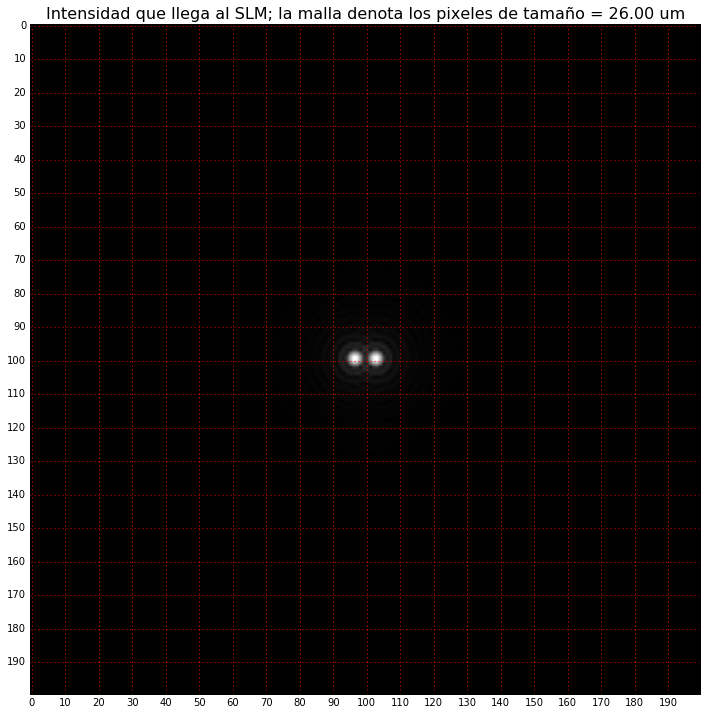

In [3]:
dxSLM = ang*f1
pixNSLM = 20 # número de píxeles por lado a observar
RespixSLM = 10 # resolución muestreo por pixel del SLM
N = RespixSLM*pixNSLM # Tamaño matriz simulación spots reales
x = np.linspace(-pixNSLM*pixSLM,pixNSLM*pixSLM,N) # espacio x-coord
X,Y = np.meshgrid(x,x) # espacio coordenado 2D
R = np.sqrt((X+dxSLM/2)**2 + Y**2) # coordenada radial
Star = (0.25*D**2/R**2)*jv(1,np.pi*D*R/(wl*f1))**2 # Patron estrella, sobre el eje
#Star =zoomC(int(Zoom*len(Star)),len(Star),imresize(Star,Zoom))
#dx = Zoom*dx
R = np.sqrt((X-dxSLM/2)**2 + Y**2) # coordenada radial desplazada para planeta
planet = (0.25*D**2/R**2)*jv(1,np.pi*D*R/(wl*f1))**2 # patrón planeta fuera del eje
#planet = zoomC(int(Zoom*len(Star)),len(Star),imresize(planet,Zoom))
PlanoSLM = Star + ratio*planet # Intensidad en el plano detector; planeta con intensidad máxima menor a la estrella


fig = plt.figure(figsize=(12,12))
plt.title(r'Intensidad que llega al SLM; la malla denota los pixeles de tamaño = %.2f um' % (pixSLM*1e6),fontsize=16)
ax = fig.gca()
ax.set_xticks(np.linspace(0, N, pixNSLM+1))
ax.set_yticks(np.linspace(0, N, pixNSLM+1))
plt.imshow(PlanoSLM**0.5,cmap='gray',)
plt.grid(color='red',lw=1)
#plt.colorbar()
plt.show()



### Plano Detector Cámara
Se presenta la imagen observada en el detector luego del aumento programado. La malla corresponde a los pixeles del detector.

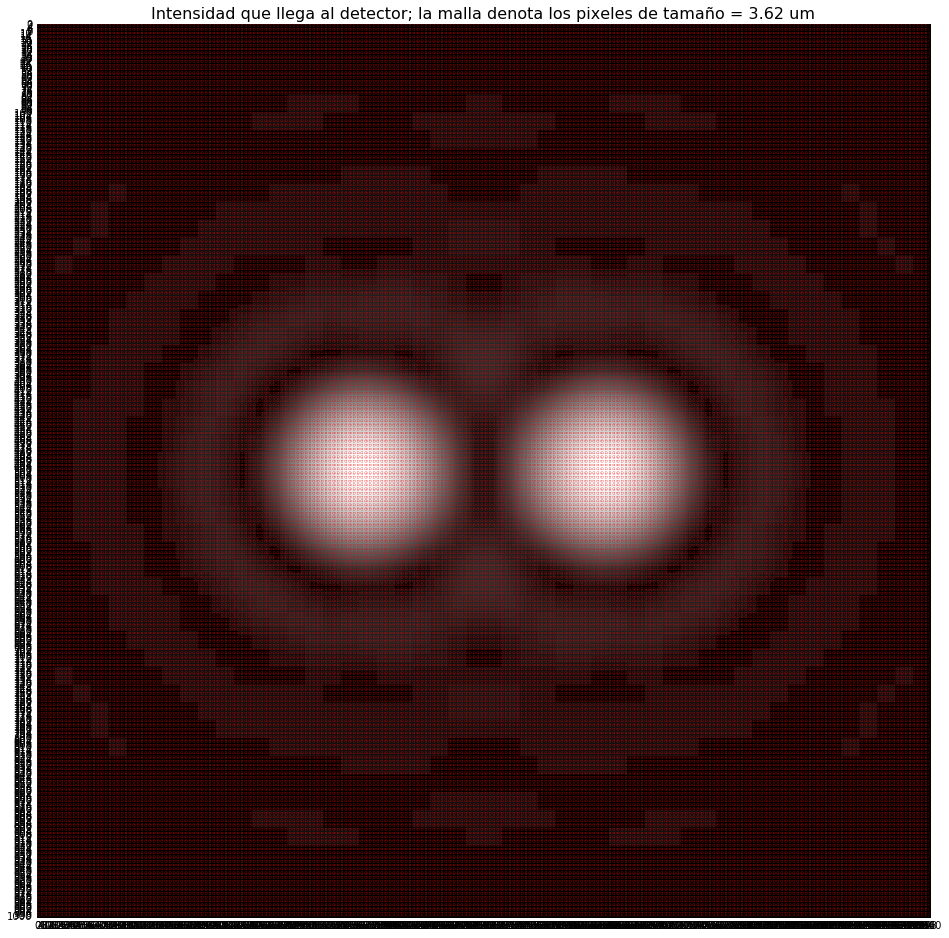

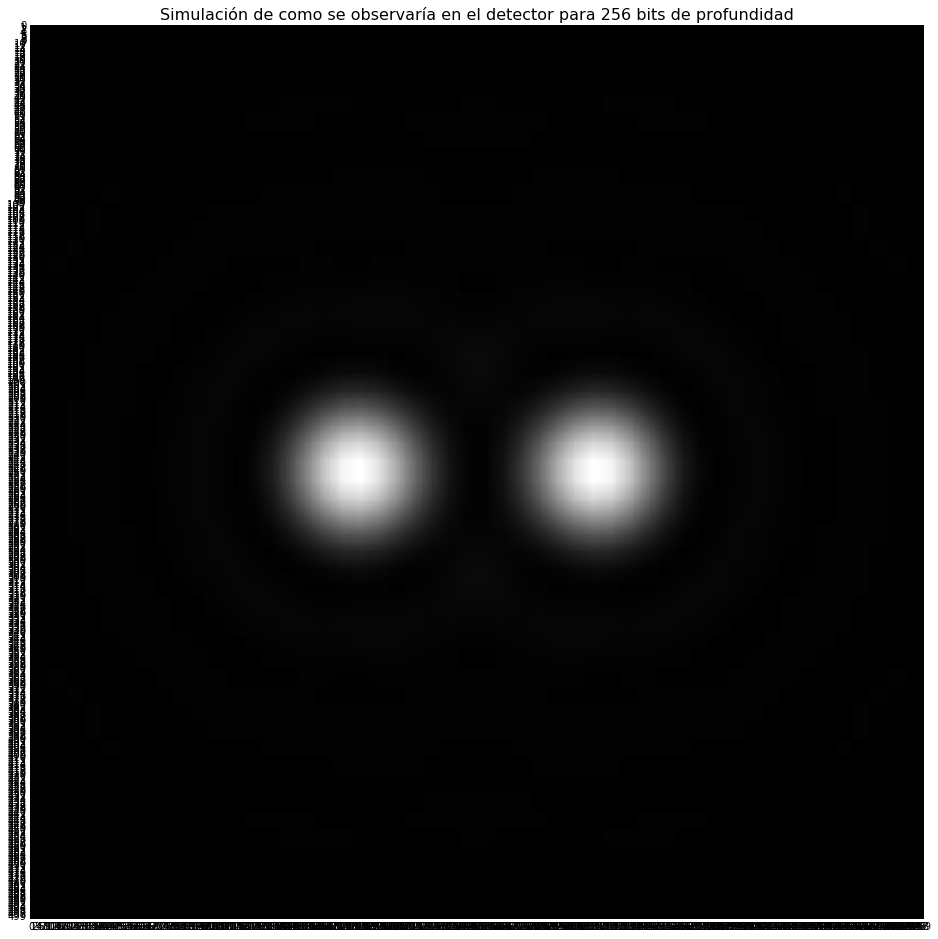

In [4]:
N = Respix*pixN # Tamaño matriz simulación spots reales
x = np.linspace(-pixN*pix,pixN*pix,N) # espacio x-coord
X,Y = np.meshgrid(x,x) # espacio coordenado 2D
R = np.sqrt((X+dx/2)**2 + Y**2) # coordenada radial
Star = (0.25*D**2/R**2)*jv(1,np.pi*D*R/(wl*f))**2 # Patron estrella, sobre el eje
#Star =zoomC(int(Zoom*len(Star)),len(Star),imresize(Star,Zoom))
#dx = Zoom*dx
R = np.sqrt((X-dx/2)**2 + Y**2) # coordenada radial desplazada para planeta
planet = (0.25*D**2/R**2)*jv(1,np.pi*D*R/(wl*f))**2 # patrón planeta fuera del eje
#planet = zoomC(int(Zoom*len(Star)),len(Star),imresize(planet,Zoom))
Plano = Star + ratio*planet # Intensidad en el plano detector; planeta con intensidad máxima menor a la estrella
Plano = zoomC(int(Zoom*len(Star)),len(Star),imresize(Plano,Zoom))

# Simulación de visualización con detector segun resolución pixeles y resolución rango dinámico
Detector = np.zeros((pixN,pixN))
for ii in range(pixN):
    for jj in range(pixN):
        Aux = np.sum(Plano[ii*Respix:(ii+1)*Respix,jj*Respix:(jj+1)*Respix])
        Detector[ii,jj] = Aux
DetBit = np.ceil(levels*Detector/np.max(Detector))


fig = plt.figure(figsize=(16,16))
plt.title('Intensidad que llega al detector; la malla denota los pixeles de tamaño = %.2f um' % (pix*1e6), fontsize=16)
ax = fig.gca()
ax.set_xticks(np.linspace(0, N, pixN+1))
ax.set_yticks(np.linspace(0, N, pixN+1))
plt.imshow(Plano**0.5,cmap='gray',)
plt.grid(color='red',lw=0.5)
#plt.colorbar()
plt.show()



plt.figure(figsize=(16,16))
plt.title('Simulación de como se observaría en el detector para %g bits de profundidad'% (levels),fontsize=16)
plt.xticks(np.linspace(0, pixN, pixN+1))
plt.yticks(np.linspace(0, pixN, pixN+1))
plt.imshow(DetBit,cmap='gray',interpolation='nearest')
#plt.colorbar()
plt.show()